# 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# 2. Data Prep

**Default Values**

In [2]:
k = 10 # k-fold cross validation
seed = 12 # 12 ears
y = 'OverallPoF' # target
svm_params = { # hyper parameters
    'C': [ 0.001, 0.01, 0.1, 1, 10, 100, 1000 ], 
    'gamma': [ 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
}
gb_params = {
    'loss': [ 'log_loss', 'deviance' ],
    'learning_rate': [ 0.001, 0.005, 0.01, 0.05, 0.1 ],
    'min_samples_split': [ 0.1, 0.15, 0.2 ],
    'min_samples_leaf': [ 0.1, 0.15, 0.2 ],
    'max_depth': [ 3, 5, 7, 9 ],
    'max_features': [ 'log2', 'sqrt', None ],
    'subsample': [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [ 10, 100, 1000 ]
}

**Import Data**

In [4]:
sample = '00 - Dataset/03 - Sampling Splits/00 - Original/'
# sample = '00 - Dataset/03 - Sampling Splits/01 - MN2/'
# sample = '00 - Dataset/03 - Sampling Splits/02 - SMOTE/'
# sample = '00 - Dataset/03 - Sampling Splits/03 - SMOTEENN/'
# sample = '00 - Dataset/03 - Sampling Splits/04 - SMOTETomek/'

In [5]:
X_train = pd.read_csv(sample + 'X_train.csv')
y_train = pd.read_csv(sample + 'y_train.csv')
X_val = pd.read_csv(sample + 'X_val.csv')
y_val = pd.read_csv(sample + 'y_val.csv')
X_test = pd.read_csv(sample + 'X_test.csv')
y_test = pd.read_csv(sample + 'y_test.csv')

**Data Scaling**

In [6]:
og_scaler = StandardScaler()
X_train = pd.DataFrame(og_scaler.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(og_scaler.transform(X_val), columns = X_val.columns)
X_test = pd.DataFrame(og_scaler.transform(X_test), columns = X_test.columns)

**Extract absorbance**

In [7]:
X_train_ab = X_train.filter(regex = r'fa[0-9]*')
X_train_all = X_train[ X_train.columns[ : 118 ] ]

X_val_ab = X_val.filter(regex = r'fa[0-9]*')
X_val_all = X_val[ X_val.columns[ : 118 ] ]

X_test_ab = X_test.filter(regex = r'fa[0-9]*')
X_test_all = X_test[ X_test.columns[ : 118 ] ]

# 3. Absorbance Only SVM

**Model**

In [8]:
base_mdl = SVC(class_weight = 'balanced', random_state = seed, kernel = 'linear')
grid = GridSearchCV(
    cv = k,
    n_jobs = -1, # use all cpu cores
    estimator = base_mdl,
    scoring = 'f1_macro',
    param_grid = svm_params,
)
grid.fit(X_train_ab, y_train[ y ])
grid.best_params_

{'C': 0.001, 'gamma': 0.001}

In [9]:
fa_svc = SVC(C = 0.001, gamma = 0.001, class_weight = 'balanced', random_state = seed, kernel = 'linear')
fa_svc.fit(X = X_train_ab, y = y_train[ y ])

SVC(C=0.001, class_weight='balanced', gamma=0.001, kernel='linear',
    random_state=12)

**Performance**

In [10]:
print(classification_report(y_train, fa_svc.predict(X_train_ab)))
print(classification_report(y_val, fa_svc.predict(X_val_ab)))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       130
           1       0.59      0.77      0.67        22

    accuracy                           0.89       152
   macro avg       0.77      0.84      0.80       152
weighted avg       0.91      0.89      0.89       152

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.88      0.91      0.90        39
weighted avg       0.93      0.92      0.92        39



<AxesSubplot:>

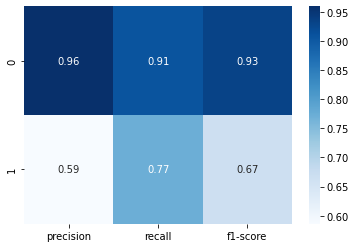

In [44]:
clf_report = classification_report(y_train, fa_svc.predict(X_train_ab), output_dict = True)
sns.heatmap(pd.DataFrame(clf_report).iloc[ : -1, : 2 ].T, annot = True, cmap = 'Blues')

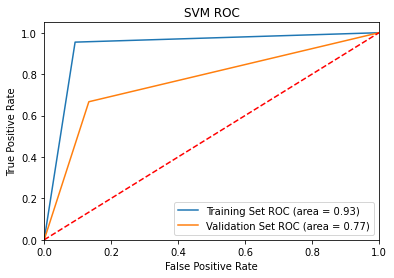

In [72]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
sets = [
    {
        'label': 'Training Set',
        'X': X_train_ab,
        'y': y_train,
    },
    {
        'label': 'Validation Set',
        'X': X_val_ab,
        'y': y_val,
    },
]

# Below for loop iterates through your models list
for s in sets:
    y_pred = fa_svc.predict(s[ 'X' ]) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(s[ 'y' ], y_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(s[ 'y' ], y_pred)
# Now, plot the computed values
    plt.plot(fpr, tpr, label = '%s ROC (area = %0.2f)' % (s[ 'label' ], auc))
# Custom settings for the plot 
plt.plot([ 0, 1 ], [ 0, 1 ],'r--')
plt.xlim([ 0.0, 1.0 ])
plt.ylim([ 0.0, 1.05 ])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc = 'lower right')
plt.show()   # Display

There are clear signs of overfitting. Especially recall for class 1 drop significantly.

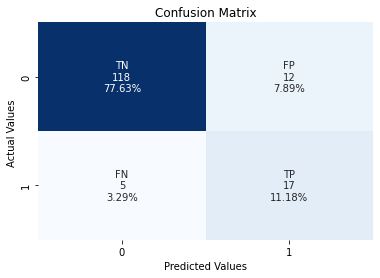

In [10]:
def conf_plot(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    labels = [ 'TN','FP','FN','TP' ]
    counts = [ 
        '{0:0.0f}'.format(value) for value in cf_matrix.flatten()
    ]
    percents = [ 
        '{0:.2%}'.format(value/ np.sum(cf_matrix)) for value in cf_matrix.flatten()
    ]
    annots = [
        f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percents)
    ]
    
    ax = sns.heatmap(
        data = cf_matrix, 
        annot = np.asarray(annots).reshape(2, 2), 
        fmt = '', 
        cmap = 'Blues', 
        cbar = False
    )
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels([ '0', '1' ])
    ax.yaxis.set_ticklabels([ '0', '1' ])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
conf_plot(y_true = y_train, y_pred = fa_svc.predict(X_train_ab))

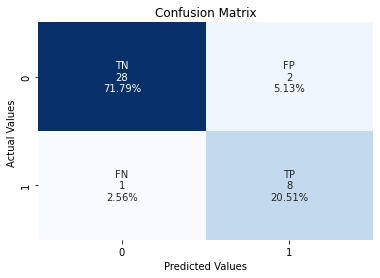

In [11]:
conf_plot(y_true = y_val, y_pred = fa_svc.predict(X_val_ab))

Text(0.5, 1.0, "SVM's Top 5 Important Features")

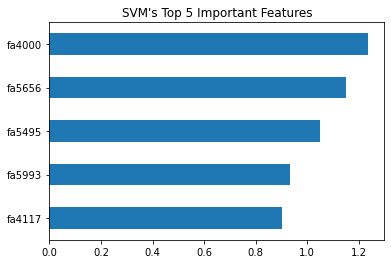

In [75]:
coef_plot = pd.Series(
    data = abs(fa_svc.coef_[ 0 ]), 
    index = fa_svc.feature_names_in_
).nlargest(5).sort_values().plot(kind = 'barh')
coef_plot.set_title('SVM\'s Top 5 Important Features')

# 4. Absorbance Only Gradient Boosting

**Model**

In [13]:
fa_gb = GradientBoostingClassifier(random_state = seed)
fa_gb.fit(X = X_train_ab, y = y_train[ y ])

GradientBoostingClassifier(random_state=12)

**Performance**

In [14]:
print(classification_report(y_train, fa_gb.predict(X_train_ab)))
print(classification_report(y_val, fa_gb.predict(X_val_ab)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00        22

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.88      0.91      0.90        39
weighted avg       0.93      0.92      0.92        39



There are clear signs of overfitting. Especially recall for class 1 drop significantly.

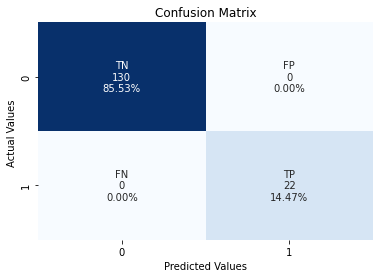

In [15]:
conf_plot(y_true = y_train, y_pred = fa_gb.predict(X_train_ab))

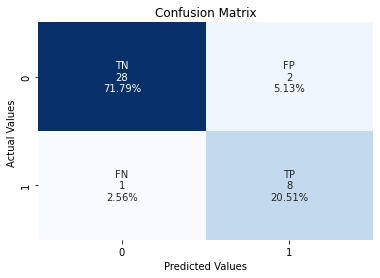

In [16]:
conf_plot(y_true = y_val, y_pred = fa_gb.predict(X_val_ab))

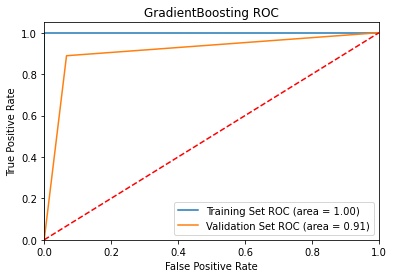

In [60]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
sets = [
    {
        'label': 'Training Set',
        'X': X_train_ab,
        'y': y_train,
    },
    {
        'label': 'Validation Set',
        'X': X_val_ab,
        'y': y_val,
    },
]

# Below for loop iterates through your models list
for s in sets:
    y_pred = fa_gb.predict(s[ 'X' ]) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(s[ 'y' ], y_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(s[ 'y' ], y_pred)
# Now, plot the computed values
    plt.plot(fpr, tpr, label = '%s ROC (area = %0.2f)' % (s[ 'label' ], auc))
# Custom settings for the plot 
plt.plot([ 0, 1 ], [ 0, 1 ],'r--')
plt.xlim([ 0.0, 1.0 ])
plt.ylim([ 0.0, 1.05 ])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GradientBoosting ROC')
plt.legend(loc = 'lower right')
plt.show()   # Display

# 5. Absorbance With All other Factors by SVM

**Model**

In [17]:
base_mdl = SVC(class_weight = 'balanced', random_state = seed, kernel = 'linear')
grid = GridSearchCV(
    cv = k,
    n_jobs = -1, # use all cpu cores
    estimator = base_mdl,
    scoring = 'f1_weighted',
    param_grid = svm_params,
)
grid.fit(X_train_all, y_train[ y ])
grid.best_params_

{'C': 0.01, 'gamma': 0.001}

In [57]:
all_svc = SVC(C = 0.01, gamma = 0.001, class_weight = 'balanced', random_state = seed, kernel = 'linear')
all_svc.fit(X = X_train_all, y = y_train[ y ])

SVC(C=0.01, class_weight='balanced', gamma=0.001, kernel='linear',
    random_state=12)

**Performance**

In [58]:
print(classification_report(y_train, all_svc.predict(X_train_all)))
print(classification_report(y_val, all_svc.predict(X_val_all)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       130
           1       0.79      0.86      0.83        22

    accuracy                           0.95       152
   macro avg       0.88      0.91      0.90       152
weighted avg       0.95      0.95      0.95       152

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.88      0.91      0.90        39
weighted avg       0.93      0.92      0.92        39



There are clear signs of overfitting. Especially recall for class 1 drop significantly.

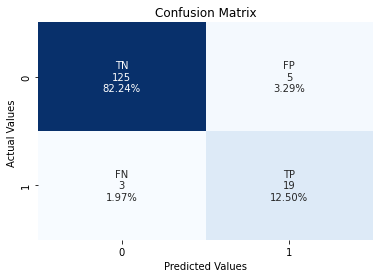

In [20]:
conf_plot(y_true = y_train, y_pred = all_svc.predict(X_train_all))

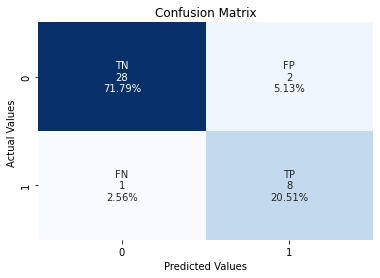

In [21]:
conf_plot(y_true = y_val, y_pred = all_svc.predict(X_val_all))

Text(0.5, 1.0, 'Top 10 Important Features')

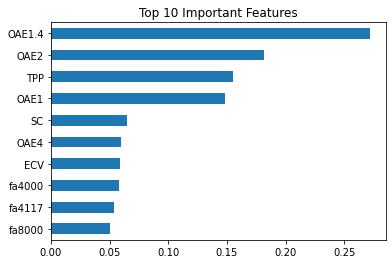

In [22]:
coef_plot = pd.Series(
    data = abs(all_svc.coef_[ 0 ]), 
    index = all_svc.feature_names_in_
).nlargest(10).sort_values().plot(kind = 'barh')
coef_plot.set_title('Top 10 Important Features')

# 6. Investigating the Fails

**Import Raw Dataset**

In [29]:
filepath = '00 - Dataset/01 - Original XLSX/WBA_Final_Merged_Absorbance-Admittance-Phase-CMG_Reduced-Cleaned.xlsx'
raw_data = pd.read_excel(filepath, sheet_name = 'Absorbance')

**Filter fails**

In [30]:
fail_data = raw_data[ raw_data[ 'OverallPoF' ] == 1 ]

**How many percent of OverallPoF fails also fail OAEPoF?**

<AxesSubplot:ylabel='OAEPoF'>

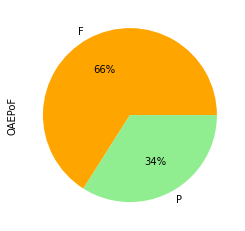

In [38]:
round(fail_data[ 'OAEPoF' ].value_counts()/ len(fail_data), 2).plot(kind = 'pie', autopct = '%1.0f%%', colors = [ 'orange', 'lightgreen' ])

**Out of those 34%, how much fails the TympPoF (ECV, TPP, SC)?**

<AxesSubplot:ylabel='TympPoF'>

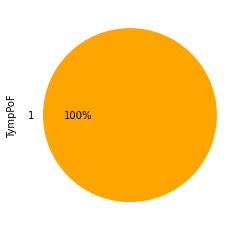

In [39]:
fail_data = fail_data[ fail_data[ 'OAEPoF' ] == 'P' ]
round(fail_data[ 'TympPoF' ].value_counts()/ len(fail_data), 2).plot(kind = 'pie', autopct = '%1.0f%%', colors = [ 'orange', 'lightgreen' ])